# Jackie Onassis Reservoir Loop

We measure the surface area of the Jackie Onassis reservoir by taking a stroll around the running track that circumscribes it. 

## Get the Data

Any number of fitness apps on smartphones and watches can track one's GPS coordinates. A common format for storing such information for routes is the `.gpx` format. Popular services like Strava can export `.gpx` files.

In [1]:
import sys
try:
    import gpxpy, ipyleaflet
except ModuleNotFoundError:
    !pip3 install ipyleaflet gpxpy --user
    import gpxpy, ipyleaflet

In [2]:
with open("ReservoirLoop.gpx") as fin:
    gpx = gpxpy.parse(fin)

In [3]:
pts = gpx.tracks[0].segments[0].points   # get the points of the route
pts.append(pts[0])                       # close the loop

In [4]:
for pt in pts[:10]:
    print(pt.latitude, pt.longitude, pt.elevation)

40.78866 -73.96194000000001 37.27
40.78846 -73.96217 37.26
40.78839000000001 -73.96231 37.26
40.78833 -73.96252000000001 37.19
40.78830000000001 -73.9628 37.24
40.78833 -73.96306000000001 37.28
40.78833 -73.96324 37.28
40.788270000000004 -73.96400000000001 37.1
40.78829 -73.96424 37.160000000000004
40.788340000000005 -73.96459 37.160000000000004


## Visualize the Data

[Leaflet](https://leafletjs.com/) is an open-source library for interactive maps. `ipyleaflet` is a Python implementation for Jupyter

In [20]:
from ipyleaflet import Map,Marker,Polyline,ScaleControl

In [30]:
JKOR = (40.785805865544326, -73.96234937449582) # lat/long of Jaquelyn Kennedy Onassis Reservoir
m = Map(center=JKOR,zoom=15)
m.add_control(ScaleControl(position='bottomleft'))
m

Map(center=[40.785805865544326, -73.96234937449582], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [31]:
path = Polyline(locations=[(p.latitude,p.longitude) for p in pts],color='green',fill=True)
m.add_layer(path)

In [10]:
# if needed
# m.remove_layer(path) 

<script> MathJax.typeset() </script>

## $xy$-coordinates

Geodata tends to be stored in latitude/longitude tuples. We need to convert to a meaningful coordinates with regard to length (like meters) if we want to compute area. Bad news: the earth is round. Good news: the earth is pretty flat. Better news still: for most anything you want to calculate, there's a [page on the (German) internet](https://rechneronline.de/earth-radius/).

In [32]:
import numpy as np
from numpy import sin, cos, pi

In [33]:
lat_0,long_0 = JKOR
deg = pi / 180             # degrees to radians
rho = 6369092              # Earth radius in meters at Central Park
phi = (90 - lat_0) * deg    # regular spherical coords
theta = long_0 * deg

def ll2xy(lat,long):
    """Converts latitude/longitude to meters east/north of Jackie O Reservoir. 
    WARNING: only works locally!"""
    dlat, dlong = lat - lat_0, long - long_0
    return rho * sin(phi) * dlong * deg, rho * dlat * deg

In [34]:
ll2xy(*JKOR)   # Check the origin

(0.0, 0.0)

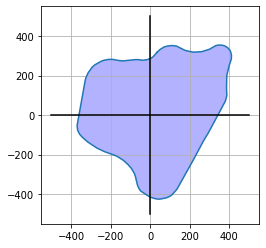

In [35]:
import matplotlib.pyplot as plt

X, Y = np.column_stack([ll2xy(pt.latitude, pt.longitude) for pt in pts])
plt.plot(X,Y)
plt.fill(X,Y,'b',alpha=.3)

# axes
plt.plot([-500,500],[0,0],'k')
plt.plot([0,0],[-500,500],'k')
plt.grid(True)
plt.gca().set_aspect('equal')


## Line integrals

Consider a line segment $\mathcal L$ from $(a,b)$ to $(c,d)$. It can be parametrized by $$\mathbf r(t) = \langle a + (c - a)t, b + (d - b)t \rangle$$ for $0 \leq t \leq 1$. 

### Arc length

First let's see how far it is around the reservoir. 

Arc length is of course $\int_C ds$, so we compute for one segment $$\int_{\mathcal L} ds = \int_0^1 \sqrt{(c-a)^2 + (d-b)^2}\,dt$$ which just gives us back the distance formula.

In [36]:
def ds(pt1, pt2):
    a, b = pt1
    c, d = pt2
    return np.sqrt((c - a)**2 + (d - b)**2)

In [37]:
arclength = 0
for i in range(len(pts) - 1):
    p, q = pts[i], pts[i + 1]
    arclength += ds(ll2xy(p.latitude, p.longitude), ll2xy(q.latitude, q.longitude))

arclength # length in meters

2535.9861417130323

In [38]:
arclength / 1609 # Give length in miles

1.5761256318912569

### Area

Green's theorem shows we can compute area of a region $D$ with positively-oriented boundary $\partial D$ by

$$\text{Area} = \iint_D dA = \iint_D 1\,dx\,dy = \int_{\partial D} x\,dy$$ On the line segment $\mathcal L$, we compute $$\int_{\mathcal L} x\,dy = \int_0^1 (a + (c - a)t) (d-b) \,dt = \frac{a + c}{2}(d - b)$$ or "the average of the $x$'s times the change in $y$" which also makes sense. 

In [15]:
def xdy(pt1, pt2):
    a, b = pt1
    c, d = pt2
    return (a + c)*(d - b)/2

In [18]:
area = 0
a = []
for i in range(len(pts)):
    p, q = pts[i], pts[(i + 1) % len(pts)]
    area += xdy(ll2xy(p.latitude, p.longitude), ll2xy(q.latitude, q.longitude))
    a.append(area)

area # area in sq. m.

398978.4871952965

In [19]:
area / 4046.86 # area in acres

98.58964411798196

## Make your own route

We can add a marker to the map, move it around, and read the location to make a new path. Try answering the question, "How big is the Morningside Heights Campus?"

In [21]:
mkr = Marker(location=JKOR)
m.add_layer(mkr)
m

Map(center=[40.785805865544326, -73.96234937449582], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [22]:
campus_pts = []    # initiate list of coordinates

In [23]:
campus_pts.append(mkr.location)   # execute every time you want to add a point to the list

In [24]:
campus_pts.append(campus_pts[0])   # close the loop